In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [2]:
expt = nsx.Experiment('test', 'BioDiff2500')
diff = expt.getDiffractometer()
filename = path.expanduser("~/data/biodiff/p11202.hdf")
reader = nsx.HDF5DataReader(filename, diff)
data = nsx.DataSet(reader, diff)
expt.addData(data)

In [3]:
kernel = nsx.AnnularKernel(data.nRows(), data.nCols())
convolver = nsx.Convolver()
convolver.setKernel(kernel.matrix())

finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationConfidence(0.98)
finder.setSearchConfidence(0.67)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

peaks = finder.find([data])
print(len(peaks))

9203


In [4]:
for peak in peaks:
    peak.setSelected(True)

In [5]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.correctedIntensity().value()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1000.0:
        continue
        
    d = 1.0 / np.linalg.norm(peak.q().rowVector())
    
    # keep peaks only in specified d range
    if d > 40.0 or d < 1.8:
        continue
        
    good_peaks.append(peak)
    
print(len(good_peaks))

3827


In [6]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

print("auto indexing", len(good_peaks), "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = diff.sample()
sample.addUnitCell(uc)

indexed_peaks = []

for peak in good_peaks:
    hkl = nsx.MillerIndex(peak.q(), uc)
    if np.linalg.norm(hkl.error()) < 0.2:
        peak.addUnitCell(uc, True)
        indexed_peaks.append(peak)
    
ch = uc.character()
print("indexed", len(indexed_peaks), "of", len(good_peaks))
print("found unit cell with parameters: ")
print("a: ", ch.a)
print("b: ", ch.b)
print("c: ", ch.c)
print("alpha: ", ch.alpha)
print("beta: ", ch.beta)
print("gamma: ", ch.gamma)

auto indexing 3827 peaks
indexed 2800 of 3827
found unit cell with parameters: 
a:  54.75836149307836
b:  58.65587507114858
c:  67.10709149319018
alpha:  1.570796326794897
beta:  1.5707963267948966
gamma:  1.5707963267948966


In [7]:
nbatches = int(data.nFrames() / 5)
#nbatches = 1
states = data.instrumentStates()

refiner = nsx.Refiner(uc, indexed_peaks, nbatches)

refiner.refineSamplePosition(states)
refiner.refineKi(states)
refiner.refineSampleOrientation(states)
#refiner.refineU()
#refiner.refineB()

success = refiner.refine(200)

print("refinement successful:", success)

refinement successful: True


In [8]:
def find_batch(peak, batches):
    z = peak.getShape().center()[2,0]
    
    for b in batches:
        if b.contains(z):
            return b
        
    return None

def reindex(peak_list, batches):          
    new_peaks = []
    
    for peak in peak_list:
        
        batch = find_batch(peak, batches)
        
        if batch is None:
            continue
        
        hkl = np.array([[0.,0.,0.]])
        uc = batch.cell()
        
        if nsx.MillerIndex(peak.q(), uc).indexed(0.2):
            peak.addUnitCell(uc, True)
            new_peaks.append(peak)
            
    return new_peaks

refined_peaks = reindex(indexed_peaks, refiner.batches())

In [42]:
import random

def close_peaks(peaks, c, r, nframes):
    c0 = np.array(c).reshape(3)
    
    close_peaks = []
    
    for peak in peaks:
        c1 = peak.getShape().center().reshape(3)
        
        if (np.linalg.norm(c0[:2]-c1[:2]) > r*r):
            continue
            
        if (np.abs(c0[2]-c1[2]) > nframes):
            continue
            
        close_peaks.append(peak)
        
    return close_peaks

def profile(peak, nx, ny, nz):
        
    c = peak.getShape().center()
    cx = int(c[0,0])
    cy = int(c[1,0])
    cz = int(c[2,0])
    
    dx = int(nx/2)
    dy = int(ny/2)
    dz = int(nz/2)
    
    x0 = cx-dx
    y0 = cy-dy
    z0 = cz-dz
    
    x1 = cx+dx+1
    y1 = cy+dy+1
    z1 = cz+dz+1
    
    shape = (z1-z0, y1-y0, x1-x0)
    p = np.zeros(shape, dtype=np.float)
    
    data = peak.data()
    nrows = data.nRows()
    ncols = data.nCols()
    nframes = data.nFrames()
    
    print(ncols, nrows, nframes)
    print(x0, y0, z0)
    print(x1, y1, z1)
    
    if (x0 < 0 or y0 < 0 or z0 < 0):
        return None
    
    if (x1 >= ncols or y1 >= nrows or z1 >= nframes):
        return None
    
    for z in range(z0, z1):
        p[z-z0, :, :] = data.frame(z)[y0:y1, x0:x1]
        
    return p
        
        
peak = random.sample(refined_peaks, 1)[0]
print(peak.getShape().center().transpose())
prof = profile(peak, 10, 10, 10)

if prof is None:
    print("none")

[[1592.04182906  431.85658848   87.50919864]]
2500 900 169
1587 426 82
1598 437 93


In [43]:
fit_peaks = close_peaks(refined_peaks, [800, 300, 50], 200, 5)
print("fit peaks:", len(fit_peaks))

profiles = []

for peak in fit_peaks:
    prof = profile(peak, 14, 14, 10)
    if prof is None:
        continue
    profiles.append((peak, prof))

fit peaks: 155
2500 900 169
866 297 42
881 312 53
2500 900 169
1004 820 43
1019 835 54
2500 900 169
961 600 44
976 615 55
2500 900 169
815 676 44
830 691 55
2500 900 169
907 713 44
922 728 55
2500 900 169
1017 149 46
1032 164 57
2500 900 169
763 350 46
778 365 57
2500 900 169
975 87 47
990 102 58
2500 900 169
1470 351 47
1485 366 58
2500 900 169
1467 371 47
1482 386 58
2500 900 169
1506 651 48
1521 666 59
2500 900 169
1604 390 48
1619 405 59
2500 900 169
1477 286 49
1492 301 60
2500 900 169
893 652 49
908 667 60
2500 900 169
1624 437 43
1639 452 54
2500 900 169
1091 856 45
1106 871 56
2500 900 169
1183 210 45
1198 225 56
2500 900 169
919 801 44
934 816 55
2500 900 169
1501 415 46
1516 430 57
2500 900 169
1498 518 46
1513 533 57
2500 900 169
948 605 47
963 620 58
2500 900 169
1004 79 49
1019 94 60
2500 900 169
1175 512 41
1190 527 52
2500 900 169
864 551 42
879 566 53
2500 900 169
1447 720 43
1462 735 54
2500 900 169
943 278 44
958 293 55
2500 900 169
1120 89 48
1135 104 59
2500 900 169

In [45]:
model_prof = np.zeros([10, 14, 14], dtype=np.float)

for peak, prof in profiles:
    prof2 = prof-peak.integration().meanBackground().value()

AttributeError: 'Peak3D' object has no attribute 'integration'

In [57]:
def background(prof):
    bkg = 0*prof + 1
    for i in range(10):
        mean = (prof*bkg).sum() / bkg.sum()
        var = ((prof - mean)**2*bkg).sum() / bkg.sum()
        std = np.sqrt(var)
        #print("mean, std: ", mean, std)
        bkg = np.abs(prof-mean) < 3*std
    return mean

def normalize(prof):
    b = background(prof)
    p = prof-b
    p /= p.sum()
    return p

fit_prof = 0*profiles[0][1]

for peak, prof in profiles:
    fit_prof += normalize(prof)
    
fit_prof /= fit_prof.sum()

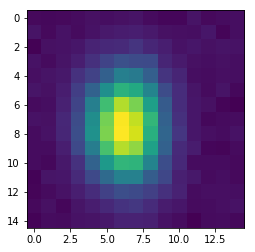

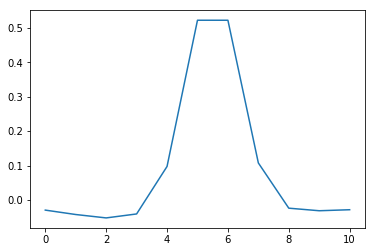

In [86]:
plt.imshow(fit_prof[5])
plt.show()

rocking = [fit_prof[z].sum() for z in range(len(fit_prof))]
plt.plot(rocking)
plt.show()

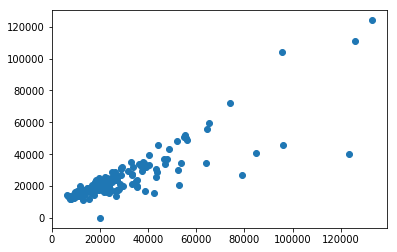

mean sum, fit: 29032.5225492548 25174.211823877034


In [79]:
def fit_intensity(obs, prof):
    I = 0
    B = 1
    
    for i in range(10):
        pred = B + I*prof
        diff = obs-pred
        ivar = 1 / pred
        
        A = np.zeros((2,2), dtype=np.float)
        b = np.zeros((2,1), dtype=np.float)
        
        A[0,0] = ivar.sum()
        A[0,1] = A[1,0] = (prof*ivar).sum()
        A[1,1] = (prof*prof*ivar).sum()
        
        b[0,0] = (obs*ivar).sum()
        b[1,0] = (obs*prof*ivar).sum()
        
        x = np.linalg.inv(A).dot(b)
        B = x[0,0]
        I = x[1,0]
        
        #print("B, I", B, I)
        
        if I < 0 or B < 0:
            break
        
    return I
    
sum_I = []
fit_I = []
    
for peak, prof in profiles:
    fit_I.append(fit_intensity(prof, fit_prof))
    sum_I.append(peak.getRawIntensity().value())
    
plt.scatter(sum_I, fit_I)
plt.show()

sum_I = np.array(sum_I)
fit_I = np.array(fit_I)

print("mean sum, fit:", sum_I.mean(), fit_I.mean())

In [184]:
import random
dt = random.sample(fit_data, 1)[0]

plt.imshow(S)
plt.show()

Sfit = model.predict(dt)

plt.imshow(Sfit)
plt.show()

w_obs, u_obs = np.linalg.eig(S)
w_fit, u_fit = np.linalg.eig(Sfit)

print(w_obs)
print(w_fit)


print(S.transpose().dot(Sfit).trace() / np.linalg.norm(S) / np.linalg.norm(Sfit))

NameError: name 'S' is not defined

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in log


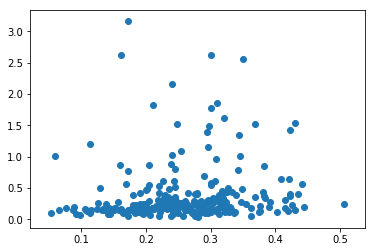

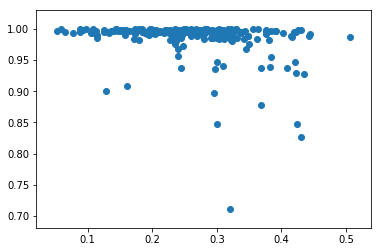

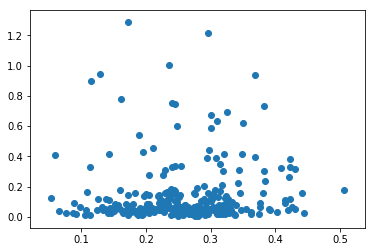

number of good peaks: 259
mean pearson: 0.9872918300228175
mean error: 0.3820858878965207
[-5.47350136e-06 -2.96809849e-05 -2.28781766e-05]
[ 1.16038554e-03 -1.72637081e-06  7.07631399e-07]
[3.66807707e-07 2.58737734e-07 2.77880764e-07]
[-9.62073871e+03  4.84091519e+00  8.94100120e-02]
[ 1.16038770e-03 -2.96968480e-05 -2.29004445e-05 -7.24293552e-06
  2.47067190e-06 -1.72321769e-06  3.96256112e-07  2.66385002e-07
  2.79997647e-07]


In [344]:
errors = []
KL_errors = []
pearson = []
qs = []

#good_fit_data = fit_data

new_fit_data = []

for dt in fit_data:
    pred = model.predict(dt)
    
    #err = np.linalg.norm(S-Sfit)
    err = np.linalg.norm(pred-dt.cov) /np.linalg.norm(dt.cov)
    
    if (err > 1e10):
        continue
    
    errors.append(err)
    KL_errors.append(KL_divergence(dt.cov, pred))
    pearson.append(dt.cov.transpose().dot(pred).trace() / np.linalg.norm(pred) / np.linalg.norm(dt.cov))
    qs.append(np.linalg.norm(dt.q))
    
    if (pearson[-1] > 0.95):
        new_fit_data.append(dt)
    
    
qs = np.array(qs)

plt.scatter(qs, errors)
plt.show()

plt.scatter(qs, pearson)
plt.show()

plt.scatter(qs, KL_errors)
plt.show()

pearson = np.array(pearson)
pmean = pearson.mean()
pstd = pearson.std()

print("number of good peaks:", len(good_fit_data))
print("mean pearson:", pmean)
print("mean error:", sum(errors)/len(errors))

result = least_squares(lambda x: ShapeModel.residual(x, new_fit_data), model.encode(), gtol=3e-16)
#print(result)

model.decode(result.x)


print_eig(model.mos)
print_eig(model.div)
print_eig(model.shape)
print_eig(model.bleed)
print_eig(model.scatter_cov())


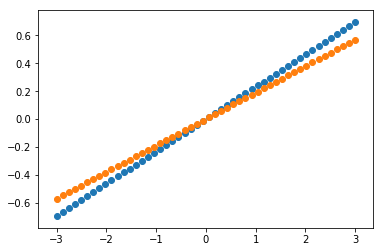

In [307]:
def ellipse_center(cov, z):
    A = np.linalg.inv(cov)
    b = A[:2,2]
    c = A[2,2]
    A2 = A[:2,:2]
    
    r2 = 1 - c*z**2 + b.transpose().dot(A2.dot(b))
    center = -np.linalg.inv(A2).dot(b)*z
    
    return center
    
    
dt = random.sample(fit_data, 1)[0]
pred_cov = model.predict(dt)
obs_cov = dt.cov

# to detector space
JI = np.linalg.inv(dt.Jd)
pred_cov = JI.dot(pred_cov).dot(JI.transpose())
obs_cov = JI.dot(obs_cov).dot(JI.transpose())

zs = np.linspace(-3, 3)

obs_xs = []
obs_ys = []

pred_xs = []
pred_ys = []

dx = []
dy = []

dc = []

for z in zs:
    c_obs = ellipse_center(obs_cov, z)
    c_pred = ellipse_center(pred_cov, z)
    
    pred_xs.append(c_pred[0])
    pred_ys.append(c_pred[1])
    
    obs_xs.append(c_obs[0])
    obs_ys.append(c_obs[1])
    
    dx.append(c_obs[0]-c_pred[0])
    dy.append(c_obs[1]-c_pred[1])
        
    dc.append(np.linalg.norm(np.array(c_obs)-np.array(c_pred)))
    
    
#plt.scatter(zs, pred_xs)
#plt.show()

#plt.scatter(obs_ys, pred_ys)
#plt.show()

plt.scatter(zs, dx)
plt.scatter(zs, dy)
plt.show()


In [ ]:
Mos, Beam, Shape, Det = decode(result.x)

w, u = np.linalg.eig(Beam)
print(np.sqrt(w) / 2.67 / np.pi * 180)
print(u)

In [ ]:
errors = []
mean = np.zeros((3,3), dtype=np.float)

good_fit_data = fit_data

for S, R, A in fit_data:
    mean += S
    
mean /= len(fit_data)

for S, R, A in fit_data:
    errors.append(np.linalg.norm(S-mean) / np.linalg.norm(S))
    
plt.plot(range(len(errors)), errors)
plt.show()

errors = np.array(errors)
print(errors.mean())
print(errors.std())

new_fit_data = []

for i in range(len(fit_data)):
    if errors[i] > errors.mean() + 3*errors.std():
        print(i, (errors[i]-errors.mean()) / errors.std())
    else:
        good_fit_data.append(fit_data[i])
               


In [ ]:
def mean_DKL(M, D, data):
    DKLs = [ DKL(S, fit_model(M, D, R, A)) for S, R, A in data]
    return np.array(DKLs).mean()

def DKL(S1, S2):
    d = 0    
    d = np.log(np.linalg.det(S2) / np.linalg.det(S1))
    d += np.linalg.inv(S2).dot(S1).trace()
    d -= S1.shape[0]
    d *= 0.5    
    return d    

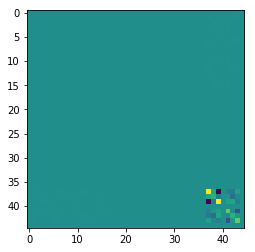

In [250]:
J = result.jac
JTJ = J.transpose().dot(J)
JTJ = 0.5 * (JTJ + JTJ.transpose())
w, u = np.linalg.eigh(JTJ)
JTJI = np.linalg.inv(JTJ)

COV = JTJI.dot(JTJI.transpose())

plt.imshow(COV)
plt.show()

In [252]:
COV

array([[ 6.50590556e+17,  1.31832199e+30, -2.53946959e+29, ...,
         3.89233886e+33,  4.74959913e+32, -3.21384682e+27],
       [ 1.31832199e+30,  1.08956550e+43, -1.91617890e+42, ...,
         4.04154536e+46,  5.95441324e+46, -2.27234766e+40],
       [-2.53946959e+29, -1.91617890e+42,  3.39464964e+41, ...,
        -7.52503397e+45, -9.70418725e+45,  3.90700538e+39],
       ...,
       [ 3.89233886e+33,  4.04154536e+46, -7.52503397e+45, ...,
         3.19351322e+50,  6.59180247e+49, -5.28978437e+43],
       [ 4.74959913e+32,  5.95441324e+46, -9.70418725e+45, ...,
         6.59180247e+49,  5.89964069e+50, -1.60717376e+44],
       [-3.21384682e+27, -2.27234766e+40,  3.90700538e+39, ...,
        -5.28978437e+43, -1.60717376e+44,  1.17940413e+38]])